## Notes

### Targets
- 5 km tempo på $s$ < 4:25 min/km.
- 10 km distance på $s$ < 4:55 min/km.
- 15 km distance på $s$ < 5:35 min/km.

### Distance training strategy
- Pick a 5 km interval (from 3 to 8 km for example) where I run 5:00 min/km, then use my natural form pace for the rest. 

### VO2 Max
Start doing VO2 max training 1 time per week. Hit 90-100% of maximum heart rate.
- Mountain march/run on treadmill: increase incline by 2% every 5 minutes.
- 4 sets of 800 meter sprints outside.
- Hill running: run up Frederikberg Slots bakke, jog down, then run up again - about 8 times.
- Race to the finish line: finish off the last 500 m of a run with higher and higher pace.

### To do


In [1]:
import calendar
from scipy.optimize import curve_fit
from scipy.stats import linregress 
import statsmodels.api as sm 
import datetime
import matplotlib.dates as pltdates
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [2]:
bg_color = "seashell"
plt.rcParams["figure.facecolor"] = bg_color
plt.rcParams["axes.facecolor"] = bg_color

In [3]:
# Træningsvariabler 
vægt = 67
alder = 33
# Løb 
løb_1km = vægt*4.7 # Konstanten er estimeret kJ brugt på løb 5-6 min/km.  
# Energi i 1 kg kropsvægt
energi_vægt = 32_200 # kJ/kg
# Styrketræning
styrke_1min = 18 # kJ forbrændt på 1 minut i styrketræning
# Konversion fra kcal til kJ:
kcal_kj = 4.184

In [4]:
# Tid og perioder 
first_day = datetime.date(2022, 8, 22)
today = datetime.date.today()
current_month = datetime.date.today().month
current_year = datetime.date.today().year 
period_delta = today - first_day 
period_days = period_delta.days
period_months = period_days/(365/12)

df = pd.read_csv('training_data.csv', sep=',')

# Gør tid til datetime midlertidigt. 
df['tid'] = pd.to_datetime(df['tid'], format='%H:%M:%S')

# Beregn tid i minutter som float. 
df['t float'] = df['tid'].dt.hour * 60 + df['tid'].dt.minute + df['tid'].dt.second / 60

# Formater tid tilbage til string.
df['tid'] = df['tid'].dt.strftime('%H:%M:%S')

# Formater datokolonne. 
df['dato'] = pd.to_datetime(df['dato'], format='%d-%m-%Y')
# df["dato"] = df["dato"].dt.strftime("%d-%m-%Y")

# Sorter data.
df = df.sort_values(by="dato", ascending=False)

# Konverter km til numeriske værdier og X til NaN. 
df['km'] = pd.to_numeric(df['km'], errors='coerce')

# Lav kolonne med forbrændt kJ.
df['kj'] = df.apply(lambda row: row['km'] * løb_1km if row['navn'] == 'Løb' else row['t float'] * styrke_1min, axis=1)

# Lav kolonne med min/km for løb.
df['min/km'] = df.apply(lambda row: row['t float'] / row['km'] if row['navn'] == 'Løb' else 0, axis=1)
df['tempo'] = pd.to_datetime(df['min/km'], unit='m').dt.strftime('%H:%M:%S')

# Arranger vigtigste kategorier først.
df = df[["navn", "dato", 'kategori', "km", "min/km", "tempo", "tid", "HR", "kj", "lokation", "præcis tid", "t float"]]

# Slet heart rate observationer før 30-10-2024, fordi de er falske. 
df.loc[df["dato"] < "30-10-2024", "HR"] = np.nan 

In [5]:
RHR = 60
MHR = 220 - alder
HRR = MHR - RHR
print(f'Maximum heart rate (theoretical): {MHR}')

max_obs_MHR = 186
print(f'Maximum heart rate (observed): {max_obs_MHR}')

z2 = (MHR*0.6, MHR*0.7)
print(f'Zone 2: {z2}')
t2 = RHR + (0.7 * HRR)
print(f'Threshold 2: {round(t2)}')

z3 = (MHR *0.7, MHR * 0.8)
print(f'Zone 3: {z3}')

t3 = RHR + (0.8 * HRR)
print(f'Threshold 3: {round(t3)}')

Maximum heart rate (theoretical): 187
Maximum heart rate (observed): 186
Zone 2: (112.2, 130.9)
Threshold 2: 149
Zone 3: (130.9, 149.6)
Threshold 3: 162


In [6]:
# Dataframe til løb.
df_løb = df[df['navn'] == 'Løb'].copy()
# Dataframe til styrketræning.
df_styrke = df[df['navn'] == 'Træning'].copy()

df_løb['km'] = df_løb['km'].astype(float) # Formater km. 
df_løb.set_index('dato', inplace=True) # Sæt dato som index.
cmlative_km = df_løb.resample('M')['km'].sum() # Gruppér efter måned og beregn summer.
cmlative_km = cmlative_km.reset_index() # Reset index for at få dato som kolonne igen.
df_løb = df_løb.reset_index() 

# Dataframe til plot
cmlative_km_plt = cmlative_km[-12:]

cmlative_km_record = cmlative_km.copy()
cmlative_km_record = cmlative_km_record.sort_values(by='km', ascending=False)
cmlative_km_record['place'] = np.arange(1, len(cmlative_km_record) + 1) # Tilføj kolonne med placering.

# Dataframe til styrketræning 
df_styrke['t float'] = df_styrke['t float'].astype(float) # Formater tid. 
df_styrke.set_index('dato', inplace=True) # Sæt dato som index.

cmlative_str = df_styrke.resample('M')['t float'].cumsum() # Gruppér efter måned og beregn summer.
# Reset index for at få dato som kolonne igen.
cmlative_str = cmlative_str.reset_index()[-80:] # Medtag kun de seneste 80 rækker. 

# Gennemsnit km/måned
avg_km_måned = cmlative_km_plt['km'][0:-1].sum() / 11

# Dataframe for løb med præcis tid og uden Reconstitution eller Distance. 
df_løb_spd = df_løb.copy()
df_løb_spd = df_løb_spd[
                        (df_løb_spd['kategori'] == 'Tempo')
                        & (df_løb_spd['min/km'] != 0) 
                        & (df_løb_spd['præcis tid'] == 'Y') 
                        # Kun tempotræning på distance under 10.01 km. 
                        & (df_løb_spd['km'] < 10.01) 
                        ]

df_løb_recon = df_løb.copy()
df_løb_recon = df_løb_recon[df_løb_recon['kategori'] == 'Reconstitution']

# Dataframe for distance med præcis tid. 
df_løb_dist = df_løb.copy()
df_løb_dist = df_løb_dist[(df_løb_dist['kategori'] == 'Distance') & (df_løb_dist['præcis tid'] == 'Y') 
    & (df_løb_dist['min/km'] != 0)]

# Dataframe til ugedistancer.
df_løb['km'] = df_løb['km'].astype(float) # Formater km. 
df_løb.set_index('dato', inplace=True) # Sæt dato som index.
uge_løb_df = df_løb.resample('W', closed="right")['km'].sum() # Gruppér efter måned og beregn summer.
uge_løb_df = uge_løb_df.reset_index() # Reset index for at få dato som kolonne igen.
df_løb = df_løb.reset_index()

n_weeks = 12
uge_løb_df = uge_løb_df[-n_weeks:].sort_values(by='dato', ascending=False)


In [7]:
uge_løb_df

,dato,km
399,2025-05-11,3.94
398,2025-05-04,14.99
397,2025-04-27,9.81
396,2025-04-20,12.13
395,2025-04-13,14.70
394,2025-04-06,44.75
393,2025-03-30,17.95
392,2025-03-23,42.75
391,2025-03-16,33.28
390,2025-03-09,26.51


In [8]:
marathon25_block = uge_løb_df[uge_løb_df["dato"] >= pd.Timestamp(2025, 3, 2)]
marathon25_block 

,dato,km
399,2025-05-11,3.94
398,2025-05-04,14.99
397,2025-04-27,9.81
396,2025-04-20,12.13
395,2025-04-13,14.70
394,2025-04-06,44.75
393,2025-03-30,17.95
392,2025-03-23,42.75
391,2025-03-16,33.28
390,2025-03-09,26.51


In [9]:
# Projektion for hvad jeg vil løbe resten af måneden.
first_day_proj = today.replace(day=1)
remaining_days = datetime.date(current_year, current_month\
    , calendar.monthrange(current_year, current_month)[1]) - today

def month_distance_projection():
    default_proj = avg_km_måned
        
    sum_proj = cmlative_km_plt.iloc[-1][1]
    days_delta_proj = today - first_day_proj + datetime.timedelta(days=1)
        
    # Udregn projektionen baseret på gennemsnittet denne måned
    month_projection = sum_proj + (int(sum_proj) / int(days_delta_proj.days)) * int(remaining_days.days)

    if cmlative_km_plt.iloc[-1][0].month != current_month:
    # if sum_proj < 1:
        return default_proj

    else: 
        return month_projection


## Alt træning

In [10]:
df.iloc[0:14,:]

,navn,dato,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
419,Løb,2025-05-10,Free,3.94,5.461083,00:05:27,00:21:31,141,1240.706,NaN,Y,21.516667
418,Løb,2025-05-04,Distance,10.01,5.193140,00:05:11,00:51:59,157,3152.149,NaN,Y,51.983333
417,Løb,2025-04-29,Free,3.49,5.764088,00:05:45,00:20:07,148,1099.001,NaN,Y,20.116667
416,Løb,2025-04-29,Free,1.49,4.015660,00:04:00,00:05:59,NaN,469.201,NaN,Y,5.983333
415,Løb,2025-04-27,Tempo,8.70,5.226054,00:05:13,00:45:28,163,2739.630,NaN,Y,45.466667
414,Løb,2025-04-27,Free,1.11,5.165165,00:05:09,00:05:44,NaN,349.539,NaN,Y,5.733333
413,Træning,2025-04-21,Free,NaN,0.000000,00:00:00,00:40:00,NaN,720.000,NaN,Y,40.000000
412,Træning,2025-04-20,Free,NaN,0.000000,00:00:00,00:55:00,NaN,990.000,NaN,Y,55.000000
411,Løb,2025-04-17,Tempo,5.00,5.330000,00:05:19,00:26:39,154,1574.500,NaN,Y,26.650000
410,Løb,2025-04-17,Tempo,1.85,5.828829,00:05:49,00:10:47,144,582.565,NaN,Y,10.783333


## Alt løb

In [11]:
# df_løb.sort_values(by="dato", ascending=False)[0:15]

## Ugedistancer

In [12]:
uge_løb_df

,dato,km
399,2025-05-11,3.94
398,2025-05-04,14.99
397,2025-04-27,9.81
396,2025-04-20,12.13
395,2025-04-13,14.70
394,2025-04-06,44.75
393,2025-03-30,17.95
392,2025-03-23,42.75
391,2025-03-16,33.28
390,2025-03-09,26.51


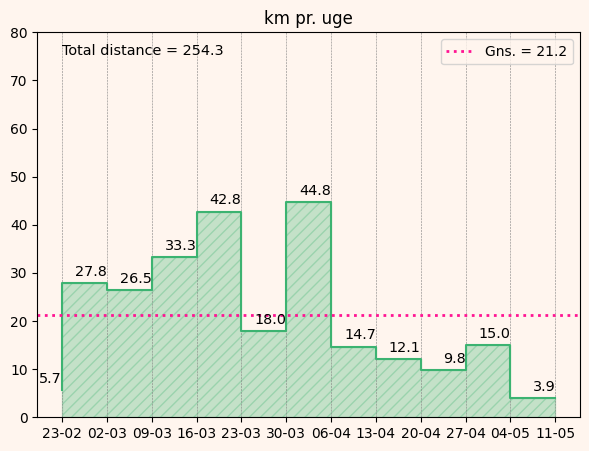

In [13]:
fig, ax = plt.subplots(figsize=(7,5))

y_max = 80

x = uge_løb_df["dato"]
y = uge_løb_df["km"]

# Ugedistancer.
ax.plot(x, y, color="mediumseagreen", drawstyle="steps-post")
ax.fill_between(x, y, step="post", hatch="///", color="mediumseagreen", alpha=0.3)

# y-værdier. 
for i in range(len(x)):
    plt.text(x.iloc[i], y.iloc[i]+1.5, str(round(y.iloc[i], 1)), ha='right', va="baseline", fontsize=10.4)

# Gennemsnit.
mean_y = np.mean(y)
ax.axhline(mean_y, color="deeppink", linewidth=2, linestyle=":", label=f"Gns. = {round(mean_y,1)}")

# Total distance.
sum_y = np.sum(y)
plt.text(x.iloc[11], y_max - (y_max*0.06), f"Total distance = {round(sum_y,1)}", fontsize=10.4)


plt.title("km pr. uge")
ax.legend()
ax.set_ylim(0, y_max)
ax.grid(True, axis="x", linestyle='--', linewidth=0.4, color='gray')
date_format_løb = pltdates.DateFormatter('%d-%m')
ax.xaxis.set_major_formatter(date_format_løb)
ax.set_xticks(x)

plt.show()

## Kilometer på et år

In [14]:
df_år_løb = df_løb[df_løb["dato"].dt.year == 2024]
år_total = df_år_løb["km"].cumsum()
print("Kilometer i 2024: ", round(år_total.values[-1], 1))
df_år_løb = df_løb[df_løb["dato"].dt.year == current_year]
år_total = df_år_løb["km"].cumsum()
print("Kilometer i år: ", round(år_total.values[-1], 1))

Kilometer i 2024:  864.3
Kilometer i år:  279.7


## Distance: kronologisk

In [15]:
df_løb_dist[:10].sort_values(by="dato", ascending=False)

,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
1,2025-05-04,Løb,Distance,10.01,5.193140,00:05:11,00:51:59,157,3152.149,NaN,Y,51.983333
12,2025-04-06,Løb,Distance,20.00,5.974167,00:05:58,01:59:29,145,6298.000,Frederiksberg,Y,119.483333
13,2025-04-05,Løb,Distance,14.00,5.850000,00:05:51,01:21:54,147,4408.600,Frederiksberg,Y,81.900000
20,2025-03-27,Løb,Distance,10.01,5.361305,00:05:21,00:53:40,153,3152.149,Frederiksberg,Y,53.666667
21,2025-03-23,Løb,Distance,17.90,5.719739,00:05:43,01:42:23,147,5636.710,Frederiksberg,Y,102.383333
22,2025-03-21,Løb,Distance,11.43,6.054243,00:06:03,01:09:12,143,3599.307,Frederiksberg,Y,69.200000
23,2025-03-20,Løb,Distance,13.42,6.102832,00:06:06,01:21:54,146,4225.958,Frederiksberg,Y,81.900000
24,2025-03-15,Løb,Distance,23.70,6.135021,00:06:08,02:25:24,155,7463.130,Frederiksberg,Y,145.400000
25,2025-03-12,Løb,Distance,9.58,5.788100,00:05:47,00:55:27,149,3016.742,Frederiksberg,Y,55.450000
27,2025-03-06,Løb,Distance,21.95,6.581625,00:06:34,02:24:28,148,6912.055,Frederiksberg,Y,144.466667


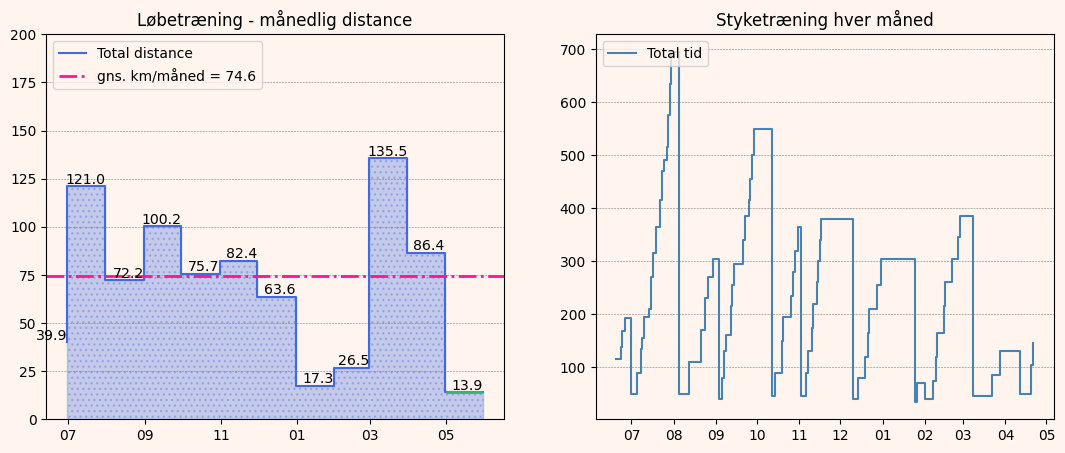

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))

# LØB 
# Plot månedssummer. 
ax[0].plot(cmlative_km_plt['dato'], cmlative_km_plt['km'], color='royalblue', drawstyle='steps-pre', label='Total distance')
ax[0].fill_between(cmlative_km_plt['dato'], cmlative_km_plt['km'], color='royalblue', step="pre", alpha=0.3, hatch="...")

# Tilføj km-værdier. 
for x, y in zip(cmlative_km_plt['dato'], cmlative_km_plt['km']):
    ax[0].text(x, y, str(round(y,1)), horizontalalignment='right', verticalalignment="bottom", fontsize=10.2)

# Linje til gennemsnit. 
ax[0].axhline(avg_km_måned, color='deeppink', linestyle="-.", linewidth=2, label=f'gns. km/måned = {round(avg_km_måned, 1)}')

# Plot fremskrivning af løbedistance for denne måned baseret på km løbet indtil nu.
ax[0].hlines(month_distance_projection(), pltdates.date2num(first_day_proj), pltdates.date2num(today+remaining_days), 
    color='mediumseagreen', linestyle='-', linewidth=2)

# STYRKE 
ax[1].plot(cmlative_str['dato'], cmlative_str['t float'], color='steelblue', drawstyle='steps-post', label='Total tid')

# GENERELT 
ax[0].set_title("Løbetræning - månedlig distance")
ax[1].set_title("Styketræning hver måned")
ax[0].grid(True, axis='y', linestyle='--', linewidth=0.4, color='gray')
ax[1].grid(True, axis='y', linestyle='--', linewidth=0.4, color='gray')
ax[0].set_ylim(0,200)
date_format_løb = pltdates.DateFormatter('%m')
ax[0].xaxis.set_major_formatter(date_format_løb)
ax[1].xaxis.set_major_formatter(date_format_løb)
ax[1].legend(loc='upper left')
ax[0].legend(loc='upper left')
plt.show()

## Tempo

In [17]:
# Lineær regression for løbehastighed.
x = (df_løb_spd['dato'] - df_løb_spd['dato'].min()).dt.days
y = df_løb_spd['min/km']
a, b, r, p, se = linregress(x, y)

def lin_spd(x):
    return a * x + b

# Multipel lineær regression.
df_løb_mreg = df_løb_spd.copy()
df_løb_mreg['dage'] = ((df_løb_mreg['dato'] - df_løb_mreg['dato'].min()).dt.days).astype(float)

y_MLR = df_løb_mreg['min/km']
X_MLR = df_løb_mreg[['dage', 'km']]

X_MLR = sm.add_constant(X_MLR)

model_MLR = sm.OLS(y, X_MLR).fit()
# print(model_MLR.summary())

def MLR_spd(x):
    return model_MLR.params[0] + model_MLR.params[1] * x
# Leave out km parameter because of insignificance.

# Exponential regression.
def exp_spd(x, alfa, beta, eta):
    return alfa * np.exp(-beta * x) + eta

p_opt, p_cov = curve_fit(exp_spd, x, y)

c:\Users\Lindholm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
# Distance MLR 
# Multipel lineær regression.
df_løb_dist_mreg = df_løb_dist.copy()
df_løb_dist_mreg = df_løb_dist_mreg.iloc[:-2,:]
df_løb_dist_mreg['dage'] = ((df_løb_dist_mreg['dato'] - df_løb_dist_mreg['dato'].min()).dt.days).astype(float)

y_dist_MLR = df_løb_dist_mreg['min/km']
X_dist_MLR = df_løb_dist_mreg[['dage', 'km']]

X_dist_MLR = sm.add_constant(X_dist_MLR)
model_dist_MLR = sm.OLS(y_dist_MLR, X_dist_MLR).fit()
# print(model_dist_MLR.summary())

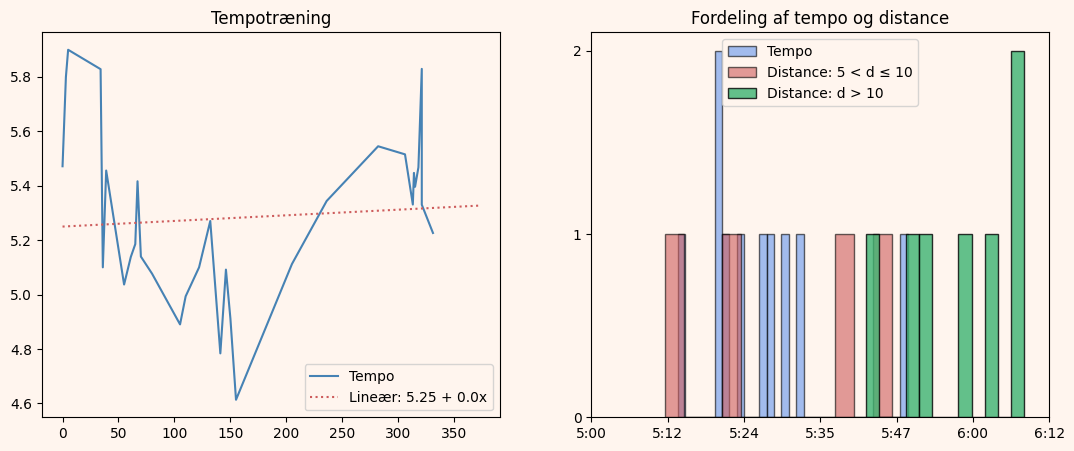

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))

# Plot for tempo.
ax[0].plot(x, df_løb_spd['min/km'], color='steelblue', label='Tempo')

l = np.linspace(0, df_løb_spd.size, df_løb_spd.size)
# Plot for simpel lineær regression.
ax[0].plot(l, lin_spd(l), color='indianred', linestyle=':', label=f'Lineær: {round(b, 2)} + {round(a, 3)}x')

# FORDELINGER 
# Fordeling af tempo. 
df_spd_distr = df_løb_spd[df_løb_spd["dato"] >= pd.Timestamp(year=2025, month=1, day=1)] 
ax[1].hist(df_spd_distr['min/km'], bins=df_løb_spd.shape[0], color='cornflowerblue', edgecolor='black', label='Tempo', alpha=0.6)
# Fordeling af distance.
# Kun nyere data fra 2025.
df_distribution = df_løb_dist[df_løb_dist["dato"] >= pd.Timestamp(year=2025, month=1, day=1)]
df_upto10 = df_distribution[(df_distribution["km"] <= 10.1) & (df_distribution["min/km"] < 6.5)]
df_over10 = df_distribution[(df_distribution["km"] > 10.1) & (df_distribution["min/km"] < 6.5)]
ax[1].hist(df_upto10["min/km"], bins=df_distribution.shape[0], color="indianred", edgecolor="black", 
    alpha=0.6, label="Distance: 5 < d \u2264 10")
ax[1].hist(df_over10["min/km"], bins=df_distribution.shape[0], color="mediumseagreen", edgecolor="black", 
    alpha=0.8, label="Distance: d > 10")

ax[0].title.set_text('Tempotræning')
ax[0].legend()
ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].title.set_text('Fordeling af tempo og distance')
ax[1].legend()
# Convert x-axis values to min:sec format. 
orig_ticks = plt.xticks()[0]
x_ticks = [f"{int(x)}:{int((x - int(x)) * 60):02d}" for x in orig_ticks]
plt.xticks(orig_ticks, x_ticks)

plt.show()

### MLR: Tempo

In [20]:
print(f'Tempoforbedring pr. dag (MLR): {round(model_MLR.params[1]*60, 3)} sek/dag')
print(f'Tempoforbedring pr. dag (lineær): {round(a*60, 3)} sek/dag')
print(f"Error = {se:.6f}")
print(f'Tempoforbedring (exp): {round(p_opt[0]*-p_opt[1]*np.exp(-p_opt[1]), 4)}x')

Tempoforbedring pr. dag (MLR): 0.012 sek/dag
Tempoforbedring pr. dag (lineær): 0.012 sek/dag
Error = 0.000496
Tempoforbedring (exp): 0.0x


In [21]:
trans_løb_spd = df_løb_spd.copy()
trans_løb_spd["log min/km"] = np.log(trans_løb_spd["min/km"]*60)
# plt.scatter(x, trans_løb_spd["log min/km"], color='mediumseagreen', label='log(km/sek)')

y = trans_løb_spd['log min/km']
a2, b2, r2, p2, se2 = linregress(x, y)

def log_lin_spd(x):
    return a2 * x + b2

# plt.plot(x, log_lin_spd(x), label=f"{a2:.5f}x+{b2:.2f}", color="indianred")
print(f"Percentage change in speed every month: {np.exp(a2*(365/12))-1:.4f}")
print(f"Error = {se2:.6f}")

# plt.title("Log linear tempo")
# plt.legend()
# plt.show()

Percentage change in speed every month: 0.0013
Error = 0.000094


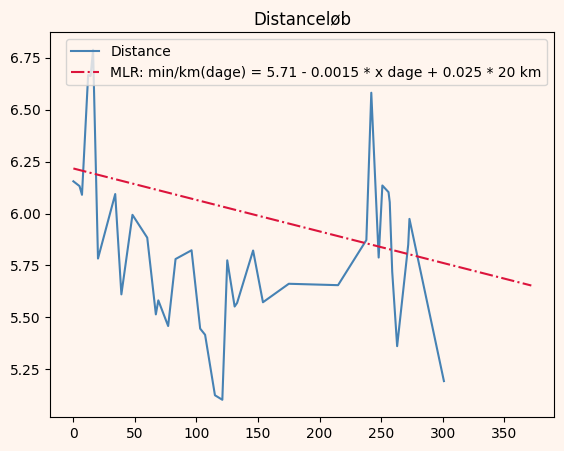

In [22]:
fig, ax = plt.subplots(ncols=1, figsize=(6.5,5))

x = (df_løb_dist_mreg['dato'] - df_løb_dist_mreg['dato'].min()).dt.days

ax.plot(x, df_løb_dist_mreg['min/km'], color='steelblue', label='Distance')

# Plot for multipel lineær regression. Konstant distanceniveau.
def f_mreg_dist(days, dist): 
    return  model_dist_MLR.params[0] + model_dist_MLR.params[1] * days + model_dist_MLR.params[2] * dist

dist = 20 # Konstant distanceniveau = 20.
ax.plot(l, f_mreg_dist(l, dist), color='crimson', linestyle='-.'
    , label=f'MLR: min/km(dage) = {round(model_dist_MLR.params[0], 2)} - {round((-1)*model_dist_MLR.params[1], 4)} * x dage + {round(model_dist_MLR.params[2], 3)} * {dist} km')

ax.title.set_text('Distanceløb')
ax.legend()
plt.show()


In [23]:
mara25 = f_mreg_dist(305, 20)
mara25 = pd.to_timedelta(mara25, unit="m")
mara25 # = 05:38 min/km. 

Timedelta('0 days 00:05:45.291165210')

### MLR: distance

In [24]:
print("Hastighedsforbedring pr. dag (distanceløb) =", round(model_dist_MLR.params[1]*60, 3), "sek/dag.")
print("Error = ", round(model_dist_MLR.bse[0], 3))

Hastighedsforbedring pr. dag (distanceløb) = -0.091 sek/dag.
Error =  0.176


## Tempoløb: kronologisk

In [25]:
df_løb_spd[:10].sort_values(by="dato", ascending=False)

,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
4,2025-04-27,Løb,Tempo,8.70,5.226054,00:05:13,00:45:28,163,2739.630,NaN,Y,45.466667
6,2025-04-17,Løb,Tempo,5.00,5.330000,00:05:19,00:26:39,154,1574.500,NaN,Y,26.650000
7,2025-04-17,Løb,Tempo,1.85,5.828829,00:05:49,00:10:47,144,582.565,NaN,Y,10.783333
8,2025-04-14,Løb,Tempo,5.28,5.467172,00:05:28,00:28:52,150,1662.672,NaN,Y,28.866667
9,2025-04-11,Løb,Tempo,5.01,5.395875,00:05:23,00:27:02,150,1577.649,NaN,Y,27.033333
10,2025-04-10,Løb,Tempo,5.00,5.446667,00:05:26,00:27:14,152,1574.500,NaN,Y,27.233333
11,2025-04-09,Løb,Tempo,4.69,5.330490,00:05:19,00:25:00,148,1476.881,Frederiksberg,Y,25.000000
14,2025-04-02,Løb,Tempo,5.60,5.514881,00:05:30,00:30:53,143,1763.440,Frederiksberg,Y,30.883333
26,2025-03-09,Løb,Tempo,4.56,5.544591,00:05:32,00:25:17,146,1435.944,Frederiksberg,Y,25.283333
33,2025-01-22,Løb,Tempo,5.87,5.343555,00:05:20,00:31:22,153,1848.463,Frederiksberg Have,Y,31.366667


## Hurtigste tempoløb

In [26]:
df_løb_spd["rank"] = df_løb_spd["min/km"].sort_values(ascending=False).rank(method="first").astype(int)
cols = ["rank"] + [col for col in df_løb_spd.columns if col != 'rank']
df_løb_spd.sort_values(by="min/km", ascending=True)[0:10][cols]


,rank,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
47,1,2024-11-02,Løb,Tempo,5.00,4.613333,00:04:36,00:23:04,165,1574.500,Frederiksberg Have,Y,23.066667
54,2,2024-10-19,Løb,Tempo,5.01,4.783766,00:04:47,00:23:58,NaN,1577.649,Søndermarken,Y,23.966667
70,3,2024-09-13,Løb,Tempo,5.01,4.890220,00:04:53,00:24:30,NaN,1577.649,Søndermarken,Y,24.500000
49,4,2024-10-28,Løb,Tempo,5.28,4.911616,00:04:54,00:25:56,NaN,1662.672,Frederiksberg Have,Y,25.933333
68,5,2024-09-18,Løb,Tempo,5.01,4.993347,00:04:59,00:25:01,NaN,1577.649,Søndermarken,Y,25.016667
90,6,2024-07-25,Løb,Tempo,5.00,5.036667,00:05:02,00:25:11,NaN,1574.500,Søndermarken,Y,25.183333
78,7,2024-08-19,Løb,Tempo,5.01,5.076514,00:05:04,00:25:26,NaN,1577.649,Søndermarken,Y,25.433333
50,8,2024-10-24,Løb,Tempo,4.19,5.091488,00:05:05,00:21:20,NaN,1319.431,Søndermarken,Y,21.333333
103,9,2024-07-06,Løb,Tempo,3.84,5.099826,00:05:05,00:19:35,NaN,1209.216,Søndermarken,Y,19.583333
60,10,2024-09-30,Løb,Tempo,7.51,5.099867,00:05:05,00:38:18,NaN,2364.899,Søndermarken,Y,38.300000


## Hurtigste distanceløb

In [27]:
df_løb_dist["rank"] = df_løb_dist["min/km"].sort_values(ascending=False).rank(method="first").astype(int)
cols = ["rank"] + [col for col in df_løb_dist.columns if col != 'rank']
df_løb_dist.sort_values(by="min/km", ascending=True)[0:10][cols]

,rank,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
46,1,2024-11-05,Løb,Distance,10.01,5.103230,00:05:06,00:51:05,157,3152.149,Frederiksberg,Y,51.083333
48,2,2024-10-30,Løb,Distance,10.00,5.125000,00:05:07,00:51:15,155,3149.000,Frederiksberg Have,Y,51.250000
1,3,2025-05-04,Løb,Distance,10.01,5.193140,00:05:11,00:51:59,157,3152.149,NaN,Y,51.983333
20,4,2025-03-27,Løb,Distance,10.01,5.361305,00:05:21,00:53:40,153,3152.149,Frederiksberg,Y,53.666667
51,5,2024-10-22,Løb,Distance,8.01,5.416146,00:05:24,00:43:23,NaN,2522.349,Frederiksberg Have,Y,43.383333
55,6,2024-10-18,Løb,Distance,9.01,5.445801,00:05:26,00:49:04,NaN,2837.249,Frederiksberg Have,Y,49.066667
63,7,2024-09-22,Løb,Distance,10.00,5.458333,00:05:27,00:54:35,NaN,3149.000,Frederiksberg Have,Y,54.583333
116,8,2024-05-20,Løb,Distance,10.00,5.510000,00:05:30,00:55:06,NaN,3149.000,Royal Run København,Y,55.100000
71,9,2024-09-12,Løb,Distance,8.10,5.514403,00:05:30,00:44:40,NaN,2550.690,Frederiksberg Have,Y,44.666667
44,10,2024-11-15,Løb,Distance,15.00,5.552222,00:05:33,01:23:17,147,4723.500,Frederiksberg Have,Y,83.283333


## Hurtigst maratontræning

In [28]:
df_løb_dist[df_løb_dist["km"] >= 15].sort_values(by="min/km")[cols]

,rank,dato,navn,kategori,km,min/km,tempo,tid,HR,kj,lokation,præcis tid,t float
44,10,2024-11-15,Løb,Distance,15.000,5.552222,00:05:33,01:23:17,147,4723.5000,Frederiksberg Have,Y,83.283333
43,11,2024-11-17,Løb,Distance,15.010,5.569620,00:05:34,01:23:36,148,4726.6490,Frederiksberg Have,Y,83.600000
35,16,2024-12-29,Løb,Distance,15.010,5.661781,00:05:39,01:24:59,145,4726.6490,Frederiksberg Have,Y,84.983333
21,17,2025-03-23,Løb,Distance,17.900,5.719739,00:05:43,01:42:23,147,5636.7100,Frederiksberg,Y,102.383333
45,18,2024-11-09,Løb,Distance,25.000,5.774667,00:05:46,02:24:22,150,7872.5000,Frederiksberg Have,Y,144.366667
61,19,2024-09-28,Løb,Distance,20.000,5.780833,00:05:46,01:55:37,NaN,6298.0000,Frederiksberg Have,Y,115.616667
28,25,2025-03-02,Løb,Distance,15.000,5.872222,00:05:52,01:28:05,151,4723.5000,Frederiksberg,Y,88.083333
254,27,2017-09-15,Løb,Distance,21.097,5.970833,00:05:58,02:05:58,NaN,6643.4453,CPH Half,Y,125.966667
12,28,2025-04-06,Løb,Distance,20.000,5.974167,00:05:58,01:59:29,145,6298.0000,Frederiksberg,Y,119.483333
77,29,2024-08-24,Løb,Distance,17.560,5.993736,00:05:59,01:45:15,NaN,5529.6440,Frederiksberg Have,Y,105.250000


## Metabolisme

In [29]:
# Mifflin-St Jeor equation for BMR with physical activity multiplier. 
metab = (10*vægt + 6.25*174 - 5*alder + 5) * kcal_kj * 1.2 # Slightly underestimated PAM.

df_metab = df.copy()

df_metab = df_metab[:150]
df_metab = df_metab.sort_values(by="dato", ascending=True)

# Calculate mean kJ before removing older months.
kj_mean_training = df_metab.describe()['kj'][1]

df_metab1 = df_metab[(df_metab['dato'].dt.year == current_year) & (df_metab['dato'].dt.month == current_month)]

df_metab1 = df_metab1.groupby('dato', as_index=False).agg({'kj': 'sum'})

# Create rows for missing date entries.
# date_range = pd.date_range(start=f"{current_year}-{current_month-1}-01", end=f"{current_year}-{current_month}-{df_metab['dato'].dt.days_in_month.max()}")
# Automatically loading the the maximum number of days in the month stopped worker. Instead:
date_range = pd.date_range(start=f"{current_year}-{current_month}-01", end=f"{current_year}-{current_month}-31")

# Drop duplicates.
# df_metab = df_metab.drop_duplicates(subset='dato')
# Reindex the DataFrame to include all dates.
df_metab1 = df_metab1.set_index('dato').reindex(date_range).fillna(0).rename_axis('dato').reset_index()

df_metab1['metab_A'] = metab

df_metab1['shifted_dato'] = df_metab1['dato'].shift(1)
df_metab1['metab_B'] = df_metab1.apply(lambda row: 0 if row['dato'] == row['shifted_dato'] else row['metab_A'], axis=1)
df_metab1['energi'] = df_metab1['metab_B'] + df_metab1['kj']

df_metab1['cmlative m'] = df_metab1['metab_B'].cumsum()
df_metab1['cmlative e'] = df_metab1['energi'].cumsum()

# Physical acitivity energy as % of total energy (both BMR and physical activity).
df_metab1['pct'] = (df_metab1['cmlative e'] - df_metab1['cmlative m']) / df_metab1['cmlative e'] * 100

# ================================================================================================================
# Dataframe for previous month.
df_metab2 = df_metab[(df_metab['dato'].dt.year == current_year) & (df_metab['dato'].dt.month == current_month -1)]

df_metab2 = df_metab2.groupby('dato', as_index=False).agg({'kj': 'sum'})

# Create rows for missing date entries.
# date_range = pd.date_range(start=f"{current_year}-{current_month-1}-01", end=f"{current_year}-{current_month}-{df_metab['dato'].dt.days_in_month.max()}")
# Automatically loading the the maximum number of days in the month stopped working.
date_range = pd.date_range(start=f"{current_year}-{current_month-1}-01", end=f"{current_year}-{current_month -1}-30")

# Drop duplicates.
# df_metab = df_metab.drop_duplicates(subset='dato')
# Reindex the DataFrame to include all dates.
df_metab2 = df_metab2.set_index('dato').reindex(date_range).fillna(0).rename_axis('dato').reset_index()

df_metab2['metab_A'] = metab

df_metab2['shifted_dato'] = df_metab2['dato'].shift(1)
df_metab2['metab_B'] = df_metab2.apply(lambda row: 0 if row['dato'] == row['shifted_dato'] else row['metab_A'], axis=1)
df_metab2['energi'] = df_metab2['metab_B'] + df_metab2['kj']

df_metab2['cmlative m'] = df_metab2['metab_B'].cumsum()
df_metab2['cmlative e'] = df_metab2['energi'].cumsum()

# Physical acitivity energy as % of total energy (both BMR and physical activity).
df_metab2['pct'] = (df_metab2['cmlative e'] - df_metab2['cmlative m']) / df_metab2['cmlative e'] * 100

In [30]:
print("Metabolism =", round(metab))
print('Mean kJ from training =', round(kj_mean_training))
print('Total mean energy per day =', round(metab + kj_mean_training))

Metabolism = 8021
Mean kJ from training = 1757
Total mean energy per day = 9777


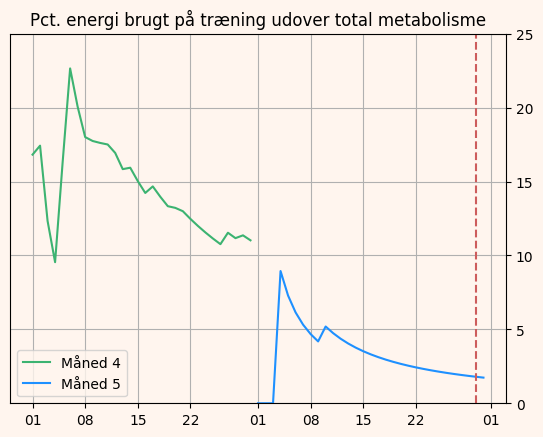

In [31]:
# Filter the DataFrame for the previous and current months.
current_month_data = df_metab1
previous_month_data = df_metab2

fig, ax = plt.subplots()

ax.plot(previous_month_data['dato'], previous_month_data['pct'], color="mediumseagreen", label=f"Måned {current_month - 1}")
ax.plot(current_month_data['dato'], current_month_data['pct'], color='dodgerblue', label=f"Måned {current_month}")

ax.xaxis.set_major_locator(pltdates.AutoDateLocator())
ax.xaxis.set_major_formatter(pltdates.DateFormatter('%d'))

ax.axvline(datetime.date.today(), color="indianred", linestyle="dashed")

ax.set_ylim(0, 25)
ax.yaxis.tick_right()
plt.grid()
plt.title('Pct. energi brugt på træning udover total metabolisme')
plt.legend()
plt.show()

### BMI
- Normalt BMI i interval $(18.5, 24.99)$

In [32]:
h = 174
kg = vægt 
mål = 21 # Mål-BMI

bmi = round(kg/(h/100)**2, 2)
print("BMI =", bmi)

def BMI(h, v):
    return v/(h/100)**2

def BMI_vægt(h, bmi):
    return ((h/100)**2)*bmi

BMI = 22.13


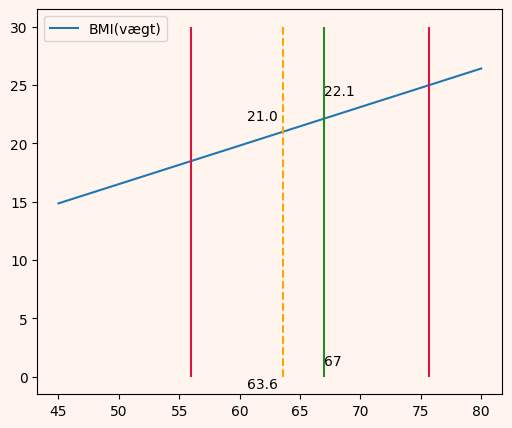

In [33]:
fig_bmi, ax_bmi = plt.subplots(figsize=(6,5))
x_bmi = np.linspace(45,80,200)

ax_bmi.plot(x_bmi, BMI(h, x_bmi), label='BMI(vægt)')
ax_bmi.vlines(BMI_vægt(h, 18.5), 0, 30, color='crimson')
ax_bmi.vlines(BMI_vægt(h, 25), 0, 30, color='crimson')
ax_bmi.vlines(kg, 0, 30, color='forestgreen')
ax_bmi.text(kg, +1, s=kg)
ax_bmi.vlines(BMI_vægt(h, mål), 0, 30, color='orange', linestyles="dashed")
ax_bmi.text(BMI_vægt(h, mål)-3, -1, s=round(BMI_vægt(h, mål),1))

# Tekst til BMI-skæringspunkt. 
ax_bmi.text(kg, BMI(h, vægt)+2, s=round(BMI(h, vægt),1))
ax_bmi.text(BMI_vægt(h, mål)-3, BMI(h, (BMI_vægt(h, mål)))+1, s=round(BMI(h, BMI_vægt(h, mål)),2))
ax_bmi.legend(loc='upper left');